### ISS VSE CA2 Part2

#### By: Kenneth Goh (A0198544N), Raymond Ng (A0198543R), Tan Heng Han (A0198502B)

In [1]:
import cv2
import os
import math
import time
import pickle
from collections import Counter
from itertools import repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

### Config

In [2]:
# Config
modelInWidth = 368
modelInHeight = 368
TEST_SIZE = 0.2
BATCH_SIZE = 2
EPOCH = 200
labels = ['NotPushUps', 'PushUps']

### Load and slice videos for training
Slice training videos into 5hz frames for model input
Data set:
1. Push up videos
2. Mixture of non push up videos

In [3]:
# Get filenames and labels for data
data_path = 'data'
files = pd.DataFrame()
filenames = []
filelabels = []
for lbl in labels:
    for ext in ('*.avi', '*.mp4'):
        path = os.path.join(data_path, lbl)
        filename = glob(os.path.join(path, ext))
        if filename: filenames.append(filename)
        if filename: 
            for idx in range(len(filename)):
                filelabels.append(lbl)

files['video_name'] = [item for sublist in filenames for item in sublist]
files['video_label'] = filelabels
files

,video_name,video_label
0,data\NotPushUps\v_PullUps_g01_c01.avi,NotPushUps
1,data\NotPushUps\v_PullUps_g01_c02.avi,NotPushUps
2,data\NotPushUps\v_PullUps_g01_c03.avi,NotPushUps
3,data\NotPushUps\v_PullUps_g01_c04.avi,NotPushUps
4,data\NotPushUps\v_PullUps_g02_c01.avi,NotPushUps
...,...,...
215,data\PushUps\Dc30U3MAzWU.mp4,PushUps
216,data\PushUps\e1.mp4,PushUps
217,data\PushUps\f1.mp4,PushUps
218,data\PushUps\kG7YKyngVLU.mp4,PushUps


In [4]:
def tryCreateVideoFolder(folderName):
    try:
        path = os.path.join('data/images/', folderName)
        if not os.path.isdir(path):
            os.mkdir(path)
    except:
        print(f'Creation of directory {folderName} failed')

In [5]:
# Slice and store the frames from training videos
for i in tqdm(range(files.shape[0])):
    count = 0
    tryCreateVideoFolder(files['video_label'][i])
    videoFile = files['video_name'][i]
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % 2 == 0):
            # storing the frames in a new folder named train_1
            filename ='data/images/' + files['video_label'][i] + '/' + videoFile.split('\\')[2].replace('.avi','').replace('.mp4','') +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [01:22<00:00,  2.68it/s]


In [6]:
%%time
# Read each images and their label into a dataframe
frames_n_labels = pd.DataFrame(columns=['frame', 'label'])
images_dir = glob('data/images/*/')
for idir in images_dir:
    iclss = idir.split('\\')[1]
    ifiles = glob(idir + '/*.jpg')
    for idx in tqdm(range(len(ifiles))):
        frame = cv2.imread(ifiles[idx])
        frames_n_labels = frames_n_labels.append(
            {'frame': frame,
             'label': iclss}, ignore_index=True)
frames_n_labels.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6943/6943 [01:02<00:00, 111.86it/s]

Wall time: 1min 40s


(13855, 2)

Text(0.5, 1.0, 'Frame Distribution')

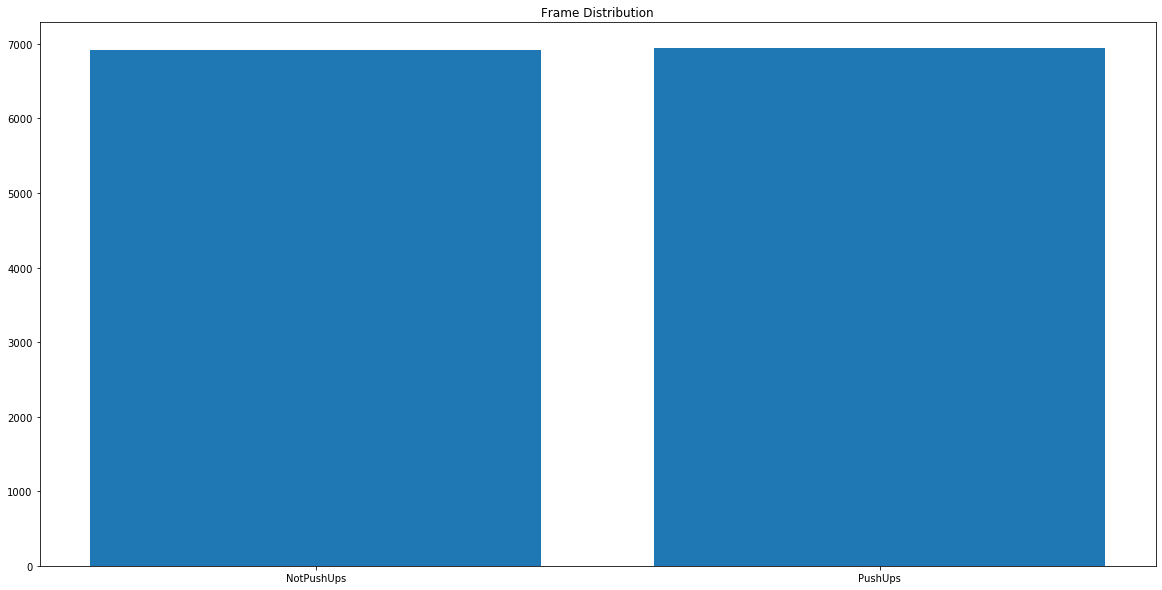

In [7]:
label_count = Counter(frames_n_labels['label'])
plt.figure(figsize=(20,10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Frame Distribution')

### Load OpenPose models

#### Instructions to get openpose models
1. Clone https://github.com/CMU-Perceptual-Computing-Lab/openpose
2. Open a console and run **openpose/models/getModels.bat**
3. Copy contents from **openpose/models/pose/coco** to **Model/coco**

In [8]:
PROTO_FILE = 'Model/coco/pose_deploy_linevec.prototxt'
WEIGHTS_FILE = 'Model/coco/pose_iter_440000.caffemodel'
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [9]:
# Load openpose model via Opencv
try:
    net = cv2.dnn.readNetFromCaffe(PROTO_FILE, WEIGHTS_FILE)
except:
    raise Exception('Error reading model, check model proto and weights file.')

### Run Openpose inference for each frame
Save heat maps for training

In [10]:
%%time
netout = []
for idx in tqdm(range(len(frames_n_labels['frame']))):
    currFrame = frames_n_labels['frame'][idx]
    inBlob = cv2.dnn.blobFromImage(currFrame, 1.0/255, (modelInWidth, modelInHeight), (0,0,0), swapRB=False, crop=False)
    net.setInput(inBlob)
    netout.append(np.swapaxes(np.squeeze(net.forward(), axis=0),0,2)) # shape=(46,46,57)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13855/13855 [6:15:58<00:00,  1.63s/it]

Wall time: 6h 15min 58s


### Pickle netout and load back

In [11]:
%%time
with open('pose.pickle','wb') as f:
    pickle.dump([frames_n_labels, netout], f)

Wall time: 2min 36s


In [12]:
%%time
with open('pose.pickle','rb') as f:
    frames_n_labels, netout = pickle.load(f)

Wall time: 24.6 s


### Check image and pose

In [13]:
# Get random image
ridx = np.random.randint(len(netout)-1)
testout = np.swapaxes(netout[ridx],2,0) # shape=(57,46,46)
img = frames_n_labels['frame'][ridx]
testimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
frameWidth = testimg.shape[1]
frameHeight = testimg.shape[0]

In [14]:
points = []
for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponging body's part.
    heatMap = testout[i, :, :]
 
    # Originally, we try to find all the local maximums. To simplify a sample
    # we just find a global one. However only a single pose at the same time
    # could be detected this way.
    _, conf, _, point = cv2.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / testout.shape[2]
    y = (frameHeight * point[1]) / testout.shape[1]
 
    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > 0.1 else None)

In [15]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)
 
    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    if points[idFrom] and points[idTo]:
        cv2.line(testimg, points[idFrom], points[idTo], (255, 74, 0), 2)
        cv2.ellipse(testimg, points[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        cv2.ellipse(testimg, points[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        cv2.putText(testimg, str(idFrom), points[idFrom], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),1,cv2.LINE_AA)
        cv2.putText(testimg, str(idTo), points[idTo], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),1,cv2.LINE_AA)

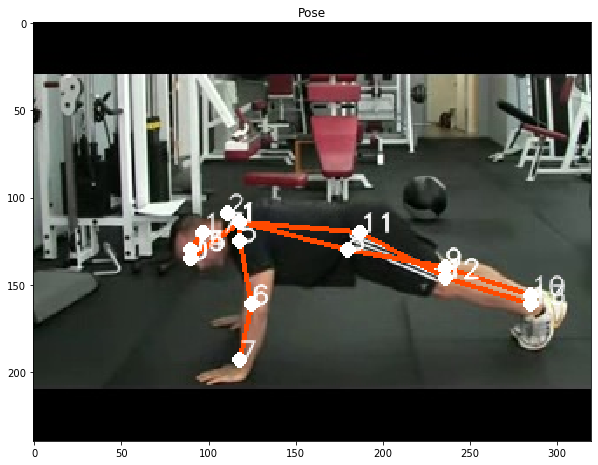

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(testimg)
plt.title('Pose')
plt.show()

### Prepare training data

In [17]:
# Keep only joints keypoints and drop PAFs
for idx in range(len(netout)):
    netout[idx] = netout[idx][:,:,0:18]
netout_stk = np.stack(netout)

In [18]:
all_lbl = np.asarray(frames_n_labels['label'])
all_lbl = all_lbl.reshape(-1,1)
oh_lbl = OneHotEncoder(sparse=False).fit_transform(all_lbl)
print(f'Labels: [{labels[0]}, {labels[1]}]')
print(f'First Label: {all_lbl[0]}')
print(f'First One Hot Encode: {oh_lbl[0]}')

Labels: [NotPushUps, PushUps]
First Label: ['NotPushUps']
First One Hot Encode: [1. 0.]


In [19]:
# Train test split
trainData, testData, trainLabel, testLabel = train_test_split(netout_stk, oh_lbl, test_size=TEST_SIZE, random_state=42, shuffle=True)

In [20]:
print(f'trainData shape: {trainData.shape}')
print(f'testData shape: {testData.shape}')
print(f'trainLabel shape: {trainLabel.shape}')
print(f'testLabel shape: {testLabel.shape}')

trainData shape: (11084, 46, 46, 18)
testData shape: (2771, 46, 46, 18)
trainLabel shape: (11084, 2)
testLabel shape: (2771, 2)


### Training Model

In [21]:
def createModel(x, y, features):
    ipt = Input(shape=(x, y, features))

    x   = Conv2D(32, (3,3), padding='same', strides=(2,2))(ipt)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(32, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(64, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    
    x   = Conv2D(64, (3,3), padding='same', strides=(2,2))(x)
    x   = BatchNormalization()(x)
    x   = Activation('relu')(x)
    x   = Dropout(0.5)(x)
       
    x   = Flatten()(x)
    x   = Dense(128, activation='relu', kernel_initializer=he_normal(42), kernel_regularizer=l2(0.001))(x)
    x   = Dense(64, activation='relu', kernel_initializer=he_normal(42), kernel_regularizer=l2(0.001))(x)
    x   = Dense(len(labels), activation='softmax')(x)
    
    model = Model(ipt, x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(), 
                  metrics=['accuracy'])
    
    return model

In [22]:
xShape, yShape, featureShape = trainData[0].shape
trainModel = createModel(xShape, yShape, featureShape)
inferModel = createModel(xShape, yShape, featureShape)
trainModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46, 46, 18)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 32)        5216      
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 12, 32)        0     

In [23]:
modelname = 'pose'
modelpath = os.path.join('Model', modelname+'.hdf5')
checkpoint = ModelCheckpoint(modelpath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')
csv_logger = CSVLogger(modelname +'.csv')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduceLr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks_list  = [checkpoint, csv_logger, early_stop, reduceLr]

In [24]:
trainModel.fit(x=trainData, y=trainLabel,
              batch_size=BATCH_SIZE,
              validation_data=(testData,testLabel),
              epochs=EPOCH,
              callbacks=callbacks_list)

Train on 11084 samples, validate on 2771 samples
Epoch 1/200
11082/11084 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9671
Epoch 00001: val_loss improved from inf to 0.10473, saving model to Model\pose.hdf5
11084/11084 [==============================] - 35s 3ms/sample - loss: 0.2294 - accuracy: 0.9671 - val_loss: 0.1047 - val_accuracy: 0.9877
Epoch 2/200
11064/11084 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9899
Epoch 00002: val_loss improved from 0.10473 to 0.05361, saving model to Model\pose.hdf5
11084/11084 [==============================] - 32s 3ms/sample - loss: 0.0588 - accuracy: 0.9899 - val_loss: 0.0536 - val_accuracy: 0.9866
Epoch 3/200
11082/11084 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9934
Epoch 00003: val_loss improved from 0.05361 to 0.03139, saving model to Model\pose.hdf5
11084/11084 [==============================] - 32s 3ms/sample - loss: 0.0369 - accuracy: 0.9934 - val_loss: 0.03

### Inference and test results

In [25]:
inferModel.load_weights(modelpath)
inferModel.compile(loss="categorical_crossentropy", 
                  optimizer=Adam(),
                  metrics=["accuracy"])

In [26]:
pred = inferModel.predict(testData, batch_size=BATCH_SIZE)
predout = np.argmax(pred, axis=1)
testout = np.argmax(testLabel, axis=1)

testScores = metrics.accuracy_score(testout, predout)
confusion  = metrics.confusion_matrix(testout, predout)

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labels,digits=4))
print(confusion)

Best accuracy (on testing dataset): 99.60%
              precision    recall  f1-score   support

  NotPushUps     0.9957    0.9964    0.9960      1386
     PushUps     0.9964    0.9957    0.9960      1385

    accuracy                         0.9960      2771
   macro avg     0.9960    0.9960    0.9960      2771
weighted avg     0.9960    0.9960    0.9960      2771

[[1381    5]
 [   6 1379]]


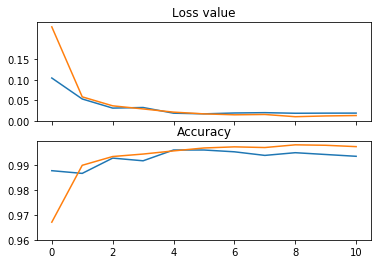

In [32]:
records = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.05,0.10,0.15])
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'])
plt.plot(records['accuracy'])
plt.yticks([0.96,0.97,0.98,0.99])
plt.title('Accuracy',fontsize=12)
plt.show()

### Run OpenPose Inference and predict image

In [78]:
testImages = []
testImgPath = 'test_image'
pushImagePath = os.path.join(testImgPath, 'push-up_test_image.jpg')
pullImagePath = os.path.join(testImgPath, 'pull-up_test_image.jpg')
testImages.append(cv2.cvtColor(cv2.imread(pushImagePath), cv2.COLOR_BGR2RGB))
testImages.append(cv2.cvtColor(cv2.imread(pullImagePath),cv2.COLOR_BGR2RGB))

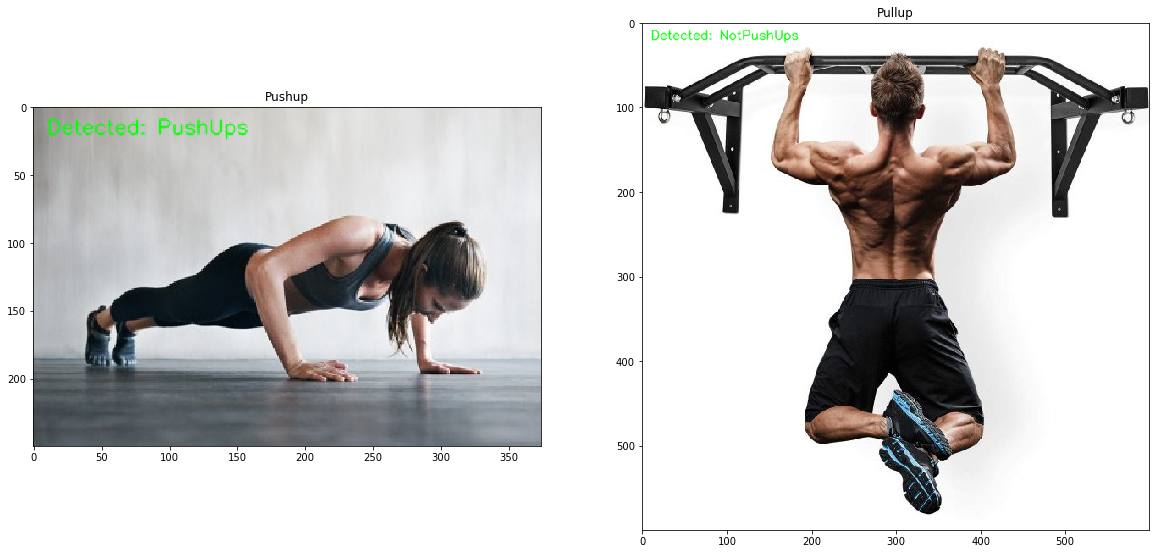

In [79]:
imgList = []
for img in testImages:
    inBlob = cv2.dnn.blobFromImage(img, 1.0/255, (modelInWidth, modelInHeight), (0,0,0), swapRB=False, crop=False)
    net.setInput(inBlob)
    img_out = np.swapaxes(np.squeeze(net.forward(), axis=0),0,2)
    img_out = img_out[:,:,0:18]
    pred_img = inferModel.predict(np.expand_dims(img_out, axis=0))
    clss = np.argmax(pred_img)
    lbl = labels[clss]
    text = "Detected: {}".format(lbl)
    cv2.putText(img,
                text,
                (10,20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0,255,0),
                1,
                cv2.LINE_AA)
    imgList.append(img)
    
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(imgList[0])
plt.title('Pushup')
plt.subplot(122)
plt.imshow(imgList[1])
plt.title('Pullup')
plt.show()

### Run Video Prediction

In [35]:
videoPath = os.path.join('test_video', 'v_Archery_g01_c02.avi')
outpath   = os.path.join('test_video', 'test9.mp4')
vs = cv2.VideoCapture(videoPath)
writer = None
(W,H) = (None, None)

In [36]:
frameCounter = 0
while True:
    (grabbed,
     frame)     = vs.read()
    frameCounter += 1
    if not grabbed:
        break
    # Initialization on the W and H
    if W is None or H is None:
        (H, W)  = frame.shape[:2]

    # Get the frame
    output      = frame.copy()
    frame       = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame       = cv2.resize(frame, (224, 224)).astype("float32")
#     frame      -= imgMean
    
    # Infer openpose
    input_blob = cv2.dnn.blobFromImage(frame, 1.0/255, (modelInWidth, modelInHeight), (0,0,0), swapRB=False, crop=False)
    net.setInput(input_blob)
    netout_org = net.forward()
    netout = np.swapaxes(np.squeeze(netout_org, axis=0),0,2)
    netout = netout[:,:,0:18] # 46, 46, 19
    
    # Perform prediction on the frame
    preds       = inferModel.predict(np.expand_dims(netout, axis=0))
    clss = np.argmax(preds)
    label = labels[clss]
    
    #########
    # ADD METHODS TO COUNT AND CHECK FOR CORRECTNESS HERE    
    #########
    
    text        = "Detected: {}".format(label)
    print(f'Frame {frameCounter} {text}')
    cv2.putText(output,
                text,
                (10,40),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0,255,0),
                2,
                cv2.LINE_AA)# This must be removed if requires real-time display

                            # Initialize the writer if this is not done
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(outpath,
                                 fourcc,
                                 30,
                                 (W, H),
                                 True)

                            # Write the output frame to disk
    writer.write(output)

                            # Real-time display the output image
#    cv2.imshow("Output", output)


print("Closing ...")
writer.release()
vs.release()

Frame 1 Detected: NotPushUps
Frame 2 Detected: NotPushUps
Frame 3 Detected: NotPushUps
Frame 4 Detected: NotPushUps
Frame 5 Detected: NotPushUps
Frame 6 Detected: NotPushUps
Frame 7 Detected: NotPushUps
Frame 8 Detected: NotPushUps
Frame 9 Detected: NotPushUps
Frame 10 Detected: NotPushUps
Frame 11 Detected: NotPushUps
Frame 12 Detected: NotPushUps
Frame 13 Detected: NotPushUps
Frame 14 Detected: NotPushUps
Frame 15 Detected: NotPushUps
Frame 16 Detected: NotPushUps
Frame 17 Detected: NotPushUps
Frame 18 Detected: NotPushUps
Frame 19 Detected: NotPushUps
Frame 20 Detected: NotPushUps
Frame 21 Detected: NotPushUps
Frame 22 Detected: NotPushUps
Frame 23 Detected: NotPushUps
Frame 24 Detected: NotPushUps
Frame 25 Detected: NotPushUps
Frame 26 Detected: NotPushUps
Frame 27 Detected: NotPushUps
Frame 28 Detected: NotPushUps
Frame 29 Detected: NotPushUps
Frame 30 Detected: NotPushUps
Frame 31 Detected: NotPushUps
Frame 32 Detected: NotPushUps
Frame 33 Detected: NotPushUps
Frame 34 Detected: 